In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:
data=pd.read_excel("BreastCancer_Prognostic_v1 (1).xlsx")

In [0]:
data.head()

,ID,Outcome,Time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


In [0]:
#Lymph_Node_Status column has ? so replace them with mean of the column.
data.replace('?', -1, inplace=True) 

In [0]:
#Converting string type to integer type in order to calculate mean.
data['Lymph_Node_Status'] = data['Lymph_Node_Status'].astype(int)

In [0]:
#Replacing -1 with mean
var1=data.Lymph_Node_Status.mean()
data.Lymph_Node_Status=data.Lymph_Node_Status.replace(-1,var1)

In [0]:
#To check if there are any -1
data[data==-1].count()

ID                           0
Outcome                      0
Time                         0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave_points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_std_dev               0
texture_std_dev              0
perimeter_std_dev            0
area_std_dev                 0
smoothness_std_dev           0
compactness_std_dev          0
concavity_std_dev            0
concave_points_std_dev       0
symmetry_std_dev             0
fractal_dimension_std_dev    0
Worst_radius                 0
Worst_texture                0
Worst_perimeter              0
Worst_area                   0
Worst_smoothness             0
Worst_compactness            0
Worst_concavity              0
Worst_concave_points         0
Worst_symmetry               0
Worst_fr

In [0]:
data.shape
#our dataset has 198 rows and 35 columns

(198, 35)

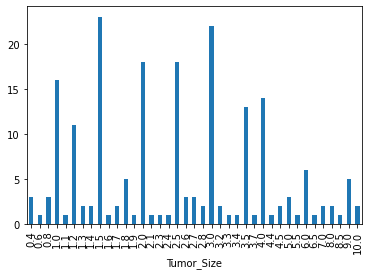

In [0]:
wc=data.groupby('Tumor_Size')['Tumor_Size'].count()
wc.plot(kind='bar')

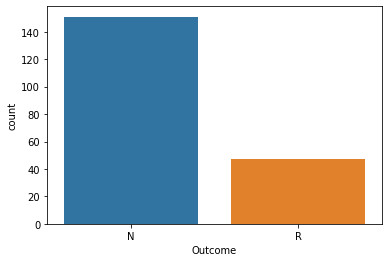

In [0]:
#count of Recurrence and non recurrence
sns.countplot(data['Outcome'],label="Count")

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         198 non-null    int64  
 1   Outcome                    198 non-null    object 
 2   Time                       198 non-null    int64  
 3   radius_mean                198 non-null    float64
 4   texture_mean               198 non-null    float64
 5   perimeter_mean             198 non-null    float64
 6   area_mean                  198 non-null    float64
 7   smoothness_mean            198 non-null    float64
 8   compactness_mean           198 non-null    float64
 9   concavity_mean             198 non-null    float64
 10  concave_points_mean        198 non-null    float64
 11  symmetry_mean              198 non-null    float64
 12  fractal_dimension_mean     198 non-null    float64
 13  radius_std_dev             198 non-null    float64

In [0]:
# Mapping Outcome column to integer type
data['Outcome']=data['Outcome'].map({'R':1,'N':0})

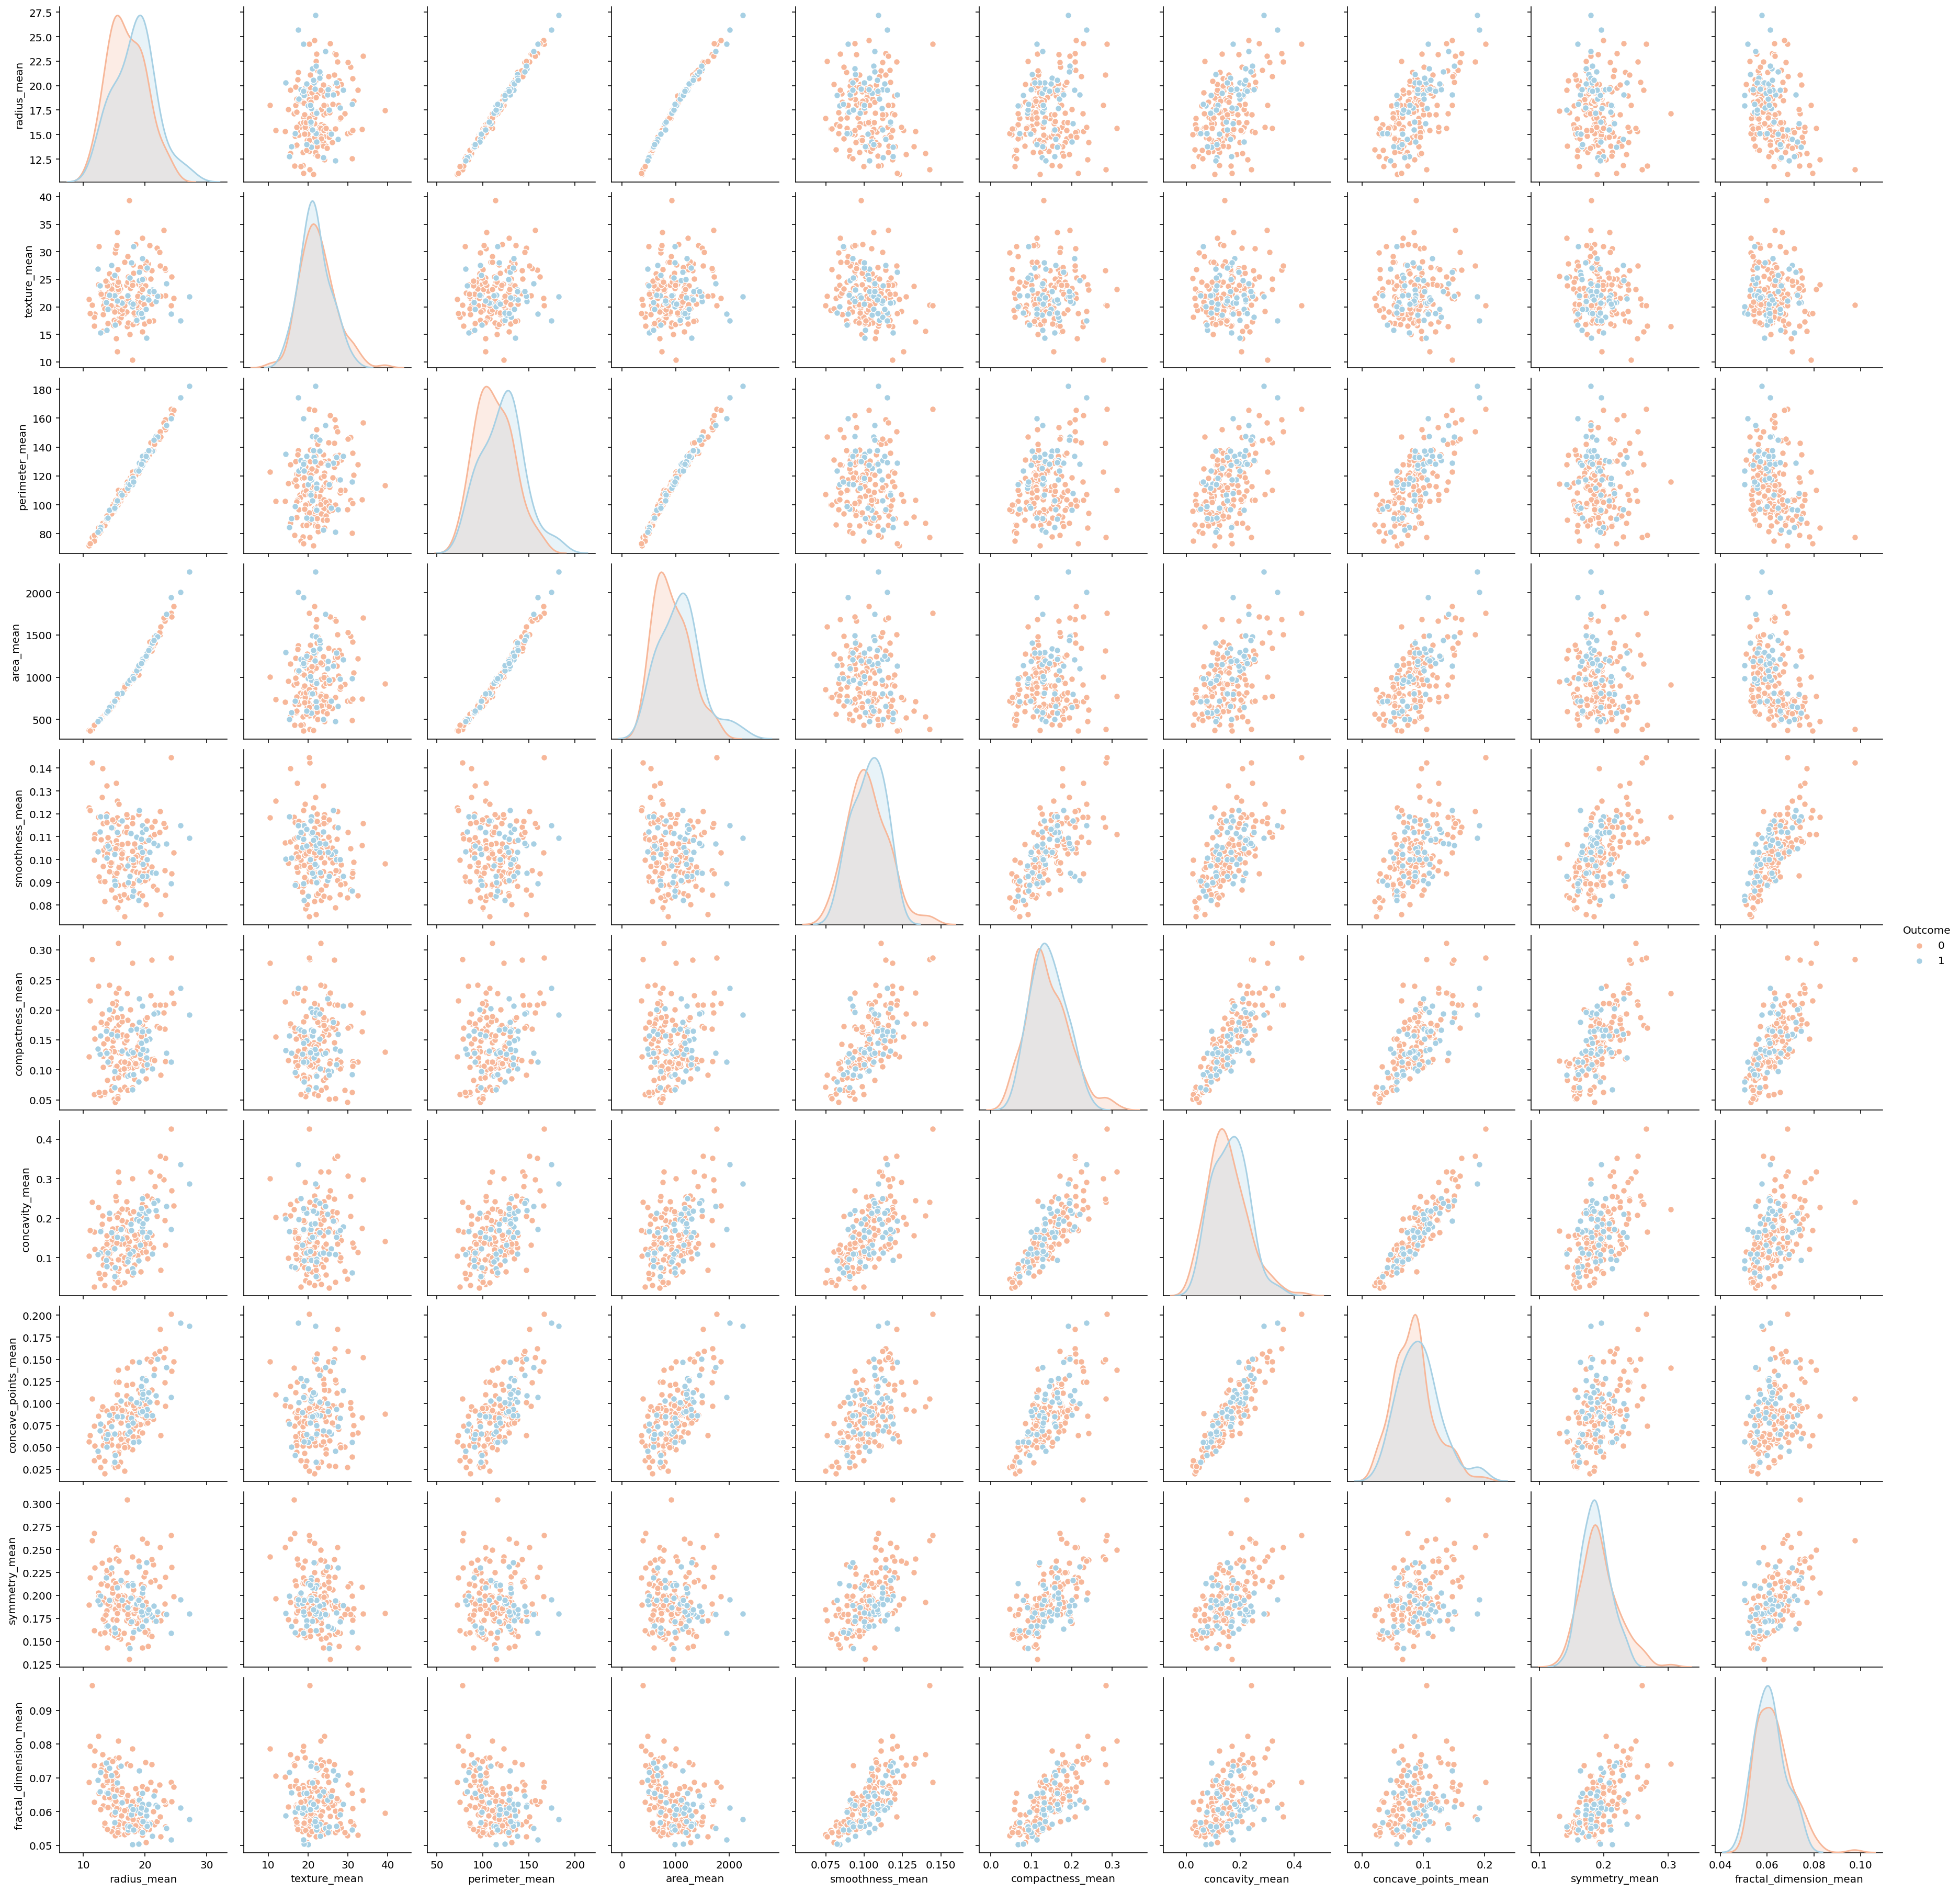

In [0]:
cols = ['Outcome',
        'radius_mean', 
       'texture_mean', 
        'perimeter_mean', 
       'area_mean', 
      'smoothness_mean', 
        'compactness_mean', 
      'concavity_mean',
        'concave_points_mean', 
        'symmetry_mean', 
      'fractal_dimension_mean']

sns.pairplot(data=data[cols], hue='Outcome', palette='RdBu')

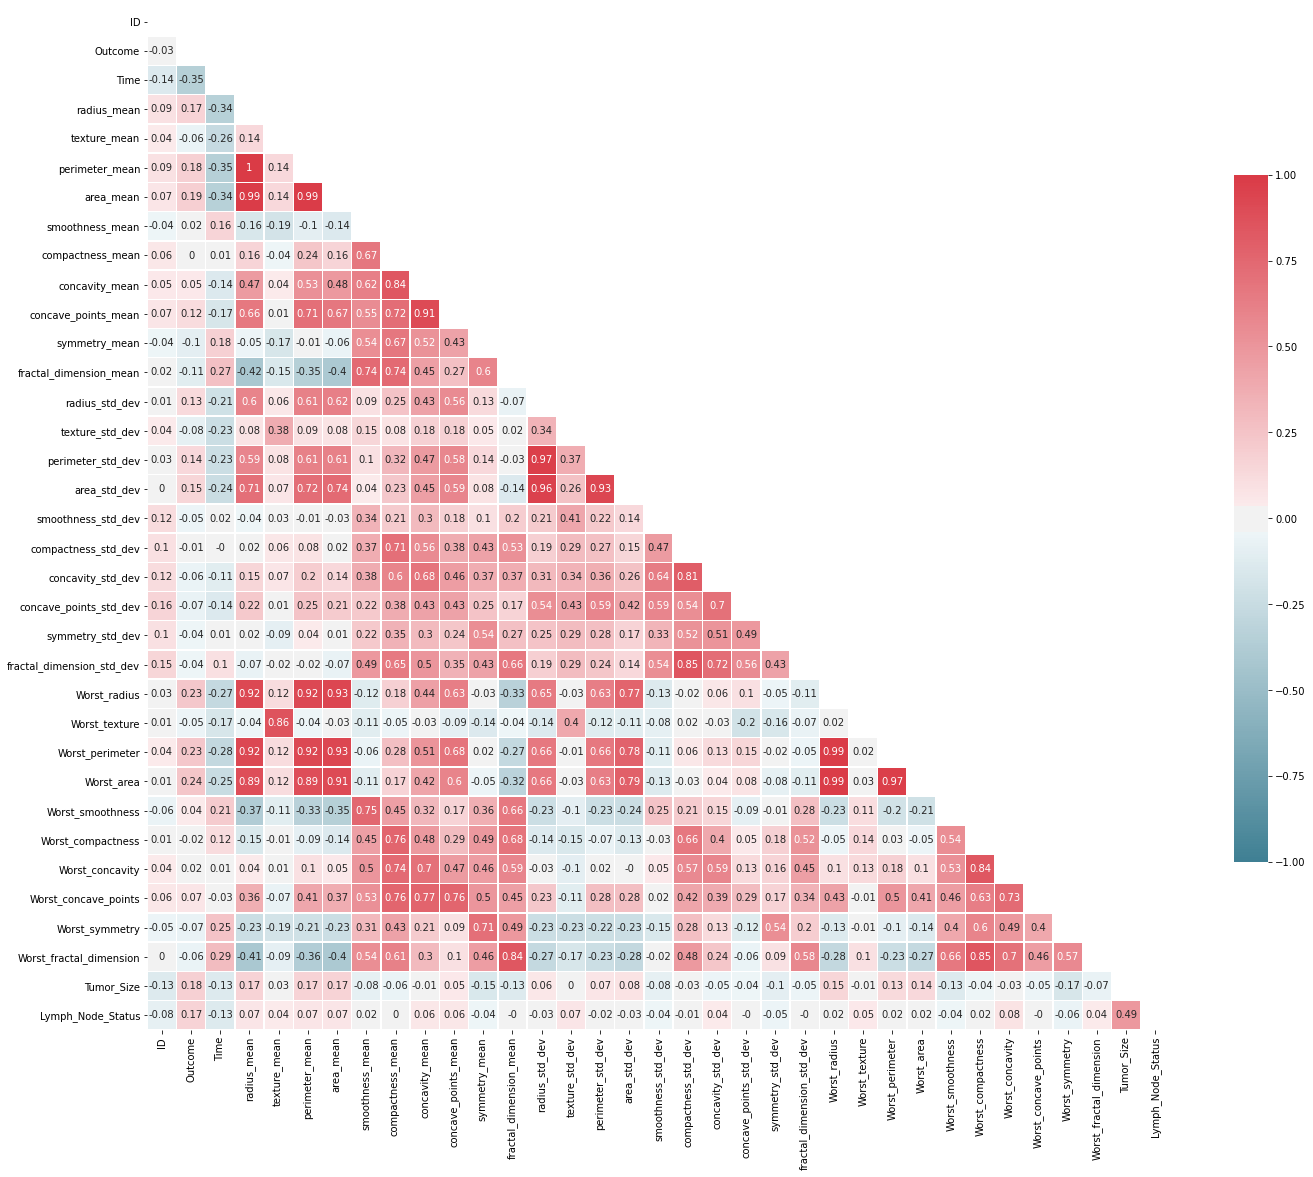

In [0]:
#Correaltion matrix for the features 
corr = data.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

We found that area perimeter and radius are realted so we will take one of them.
Similarly Concave points ,compactness and concavity are also related .
And ID and Lymph Node status will not be required to classify label hence dropping them also.

In [0]:
#Drop columns which have interdependencies between them
cols = ['Worst_radius', 'Worst_perimeter', 'Worst_area','perimeter_mean',
        'perimeter_std_dev',
        'area_mean',
        'area_std_dev','concavity_mean',
        'concavity_std_dev',
        'concave_points_mean',
        'concave_points_std_dev','Lymph_Node_Status']
data = data.drop(cols, axis=1)
data.columns


Index(['ID', 'Outcome', 'Time', 'radius_mean', 'texture_mean',
       'smoothness_mean', 'compactness_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_std_dev', 'texture_std_dev',
       'smoothness_std_dev', 'compactness_std_dev', 'symmetry_std_dev',
       'fractal_dimension_std_dev', 'Worst_texture', 'Worst_smoothness',
       'Worst_compactness', 'Worst_concavity', 'Worst_concave_points',
       'Worst_symmetry', 'Worst_fractal_dimension', 'Tumor_Size'],
      dtype='object')

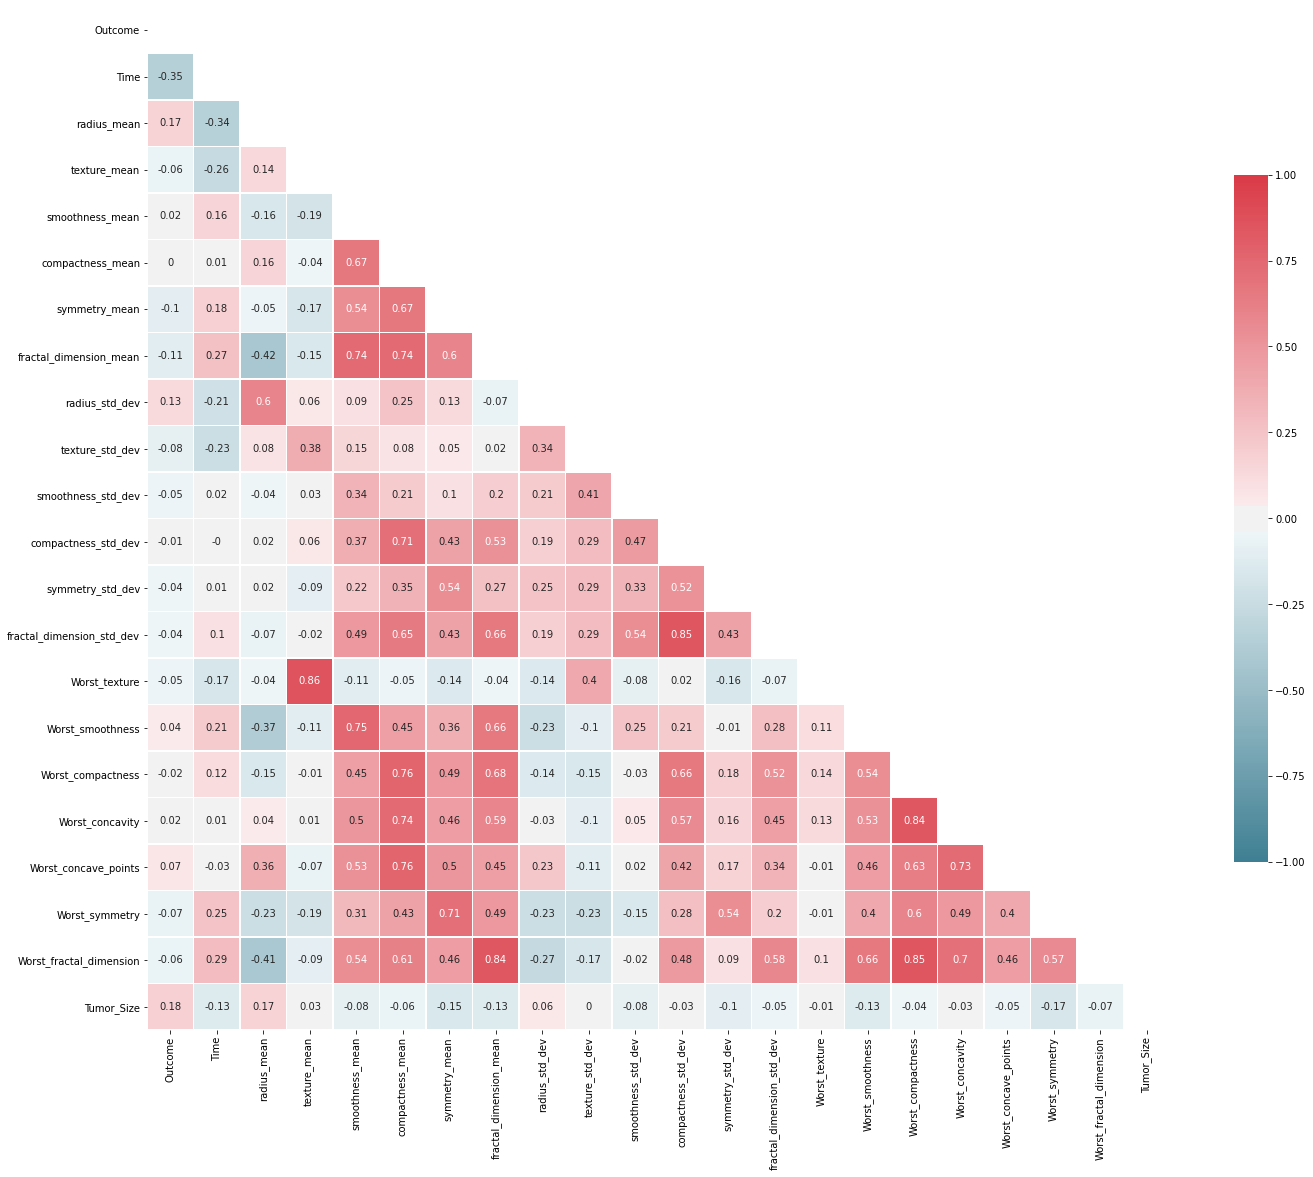

In [0]:
# Draw the heatmap again, with the new correlation matrix

corr = data.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

In [0]:
#these will be the features we will be including on the basis of correaltion matrix

prediction_var =['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_dev', 'texture_std_dev', 'smoothness_std_dev',
       'compactness_std_dev', 'symmetry_std_dev', 'fractal_dimension_std_dev',
       'Worst_texture', 'Worst_smoothness', 'Worst_compactness',
       'Worst_concavity', 'Worst_concave_points', 'Worst_symmetry',
       'Worst_fractal_dimension', 'Tumor_Size']

In [0]:
# our main data is splitted into train and test set
# we can check their dimension
train, test = train_test_split(data, test_size = 0.3)
print(train.shape)
print(test.shape)

(138, 22)
(60, 22)


In [0]:
train_X = train[prediction_var]# taking the training data input 
train_y=train.Outcome# This is output of our training data
# same we have to do for test
test_X= test[prediction_var] # taking test data inputs
test_y =test.Outcome   #output value of test data

In [0]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_y)
prediction=model.predict(test_X)
metrics.accuracy_score(prediction,test_y) # to check the accuracy

0.75

In [0]:
#To look at the confusion matrix
print(metrics.confusion_matrix(prediction,test_y))

[[45 13]
 [ 2  0]]


In [0]:
print(metrics.classification_report(prediction,test_y))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86        58
           1       0.00      0.00      0.00         2

    accuracy                           0.75        60
   macro avg       0.48      0.39      0.43        60
weighted avg       0.93      0.75      0.83        60



In [0]:
# model = svm.SVC()
# model.fit(train_X,train_y)
# prediction=model.predict(test_X)
# metrics.accuracy_score(prediction,test_y)

In [0]:
# model = LogisticRegression()
# model.fit(train_X,train_y)
# prediction=model.predict(test_X)
# metrics.accuracy_score(prediction,test_y)

We see that the accuracy is not good so we will add more rows in this by using SMOTE

In [0]:
X = data.loc[:, data.columns != 'Outcome']
y = data.Outcome

In [0]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#Now df will be our new dataset which we will be working on
df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
df.shape

(302, 23)

In [0]:
df.columns=['ID','Time', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_dev', 'texture_std_dev', 'smoothness_std_dev',
       'compactness_std_dev', 'symmetry_std_dev', 'fractal_dimension_std_dev',
       'Worst_texture', 'Worst_smoothness', 'Worst_compactness',
       'Worst_concavity', 'Worst_concave_points', 'Worst_symmetry',
       'Worst_fractal_dimension', 'Tumor_Size','Outcome'] 
df.Time=df.Time.apply(lambda x:round(x))
df.ID=df.ID.apply(lambda x:round(x))
df.head()

,ID,Time,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,smoothness_std_dev,compactness_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_texture,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Outcome
0,119513,31,18.02,27.60,0.09489,0.1036,0.1865,0.06333,0.6249,1.8900,0.004433,0.01421,0.01694,0.003495,37.08,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,0
1,8423,61,17.99,10.38,0.11840,0.2776,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.03003,0.006193,17.33,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,0
2,842517,116,21.37,17.44,0.08836,0.1189,0.2333,0.06010,0.5854,0.6105,0.006167,0.03449,0.03094,0.005039,20.98,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,123,11.42,20.38,0.14250,0.2839,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05963,0.009208,26.50,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,27,20.29,14.34,0.10030,0.1328,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.005115,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,1


In [0]:
prediction_var =['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_dev', 'texture_std_dev', 'smoothness_std_dev',
       'compactness_std_dev', 'symmetry_std_dev', 'fractal_dimension_std_dev',
       'Worst_texture', 'Worst_smoothness', 'Worst_compactness',
       'Worst_compactness', 'Worst_symmetry',

       'Worst_fractal_dimension', 'Tumor_Size']

In [0]:
train, test = train_test_split(df, test_size = 0.3)# in this our main data is splitted into train and test
# we can check their dimension
print(train.shape)
print(test.shape)

(211, 23)
(91, 23)


In [0]:
train_X = train[prediction_var]# taking the training data input 
train_y=train.Outcome# This is output of our training data
# same we have to do for test
test_X= test[prediction_var] # taking test data inputs
test_y =test.Outcome   #output value of test dat

In [0]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_y)
prediction=model.predict(test_X)
metrics.accuracy_score(prediction,test_y) # to check the accuracy

0.8021978021978022

In [0]:
metrics.confusion_matrix(prediction,test_y)

array([[34,  5],
       [13, 39]])

Now we can observe we have high precision and accuracy now

In [0]:
print(metrics.classification_report(prediction,test_y))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        39
           1       0.89      0.75      0.81        52

    accuracy                           0.80        91
   macro avg       0.80      0.81      0.80        91
weighted avg       0.82      0.80      0.80        91



**PART B**

we have to take only those columns with Recurrent type of cancer.To predict the recurrence time

In [0]:
df = df[df.Outcome!= 0]

K feature select

In [0]:
cla=['radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_dev', 'texture_std_dev', 'smoothness_std_dev',
       'compactness_std_dev', 'symmetry_std_dev', 'fractal_dimension_std_dev',
       'Worst_texture', 'Worst_smoothness', 'Worst_compactness',
       'Worst_concavity', 'Worst_concave_points', 'Worst_symmetry',
       'Worst_fractal_dimension', 'Tumor_Size']
x_reg=df[cla]
y_reg=df['Time']

In [0]:
X_reg_new=SelectKBest(score_func=f_regression, k=5).fit_transform(x_reg,y_reg)

In [0]:
print(X_reg_new[:5])

[[20.29     0.05883  0.7572   0.1625   0.07678]
 [12.75     0.07164  0.3877   0.1709   0.1179 ]
 [13.71     0.07451  0.5835   0.1556   0.1151 ]
 [14.54     0.07077  0.37     0.1712   0.1341 ]
 [16.13     0.07356  0.5692   0.2073   0.1142 ]]


In [0]:
print(x_reg.head())
#Top 5 we can see from matching above values with values below
#radius_mean,smoothness_mean,fractal_dimension_mean,Worst_concave_points,Worst_fractal_dimension

    radius_mean  texture_mean  ...  Worst_fractal_dimension  Tumor_Size
4         20.29         14.34  ...                  0.07678         3.5
5         12.75         15.29  ...                  0.11790         2.5
7         13.71         20.83  ...                  0.11510         4.0
13        14.54         27.54  ...                  0.13410         6.0
15        16.13         20.68  ...                  0.11420         3.0

[5 rows x 20 columns]


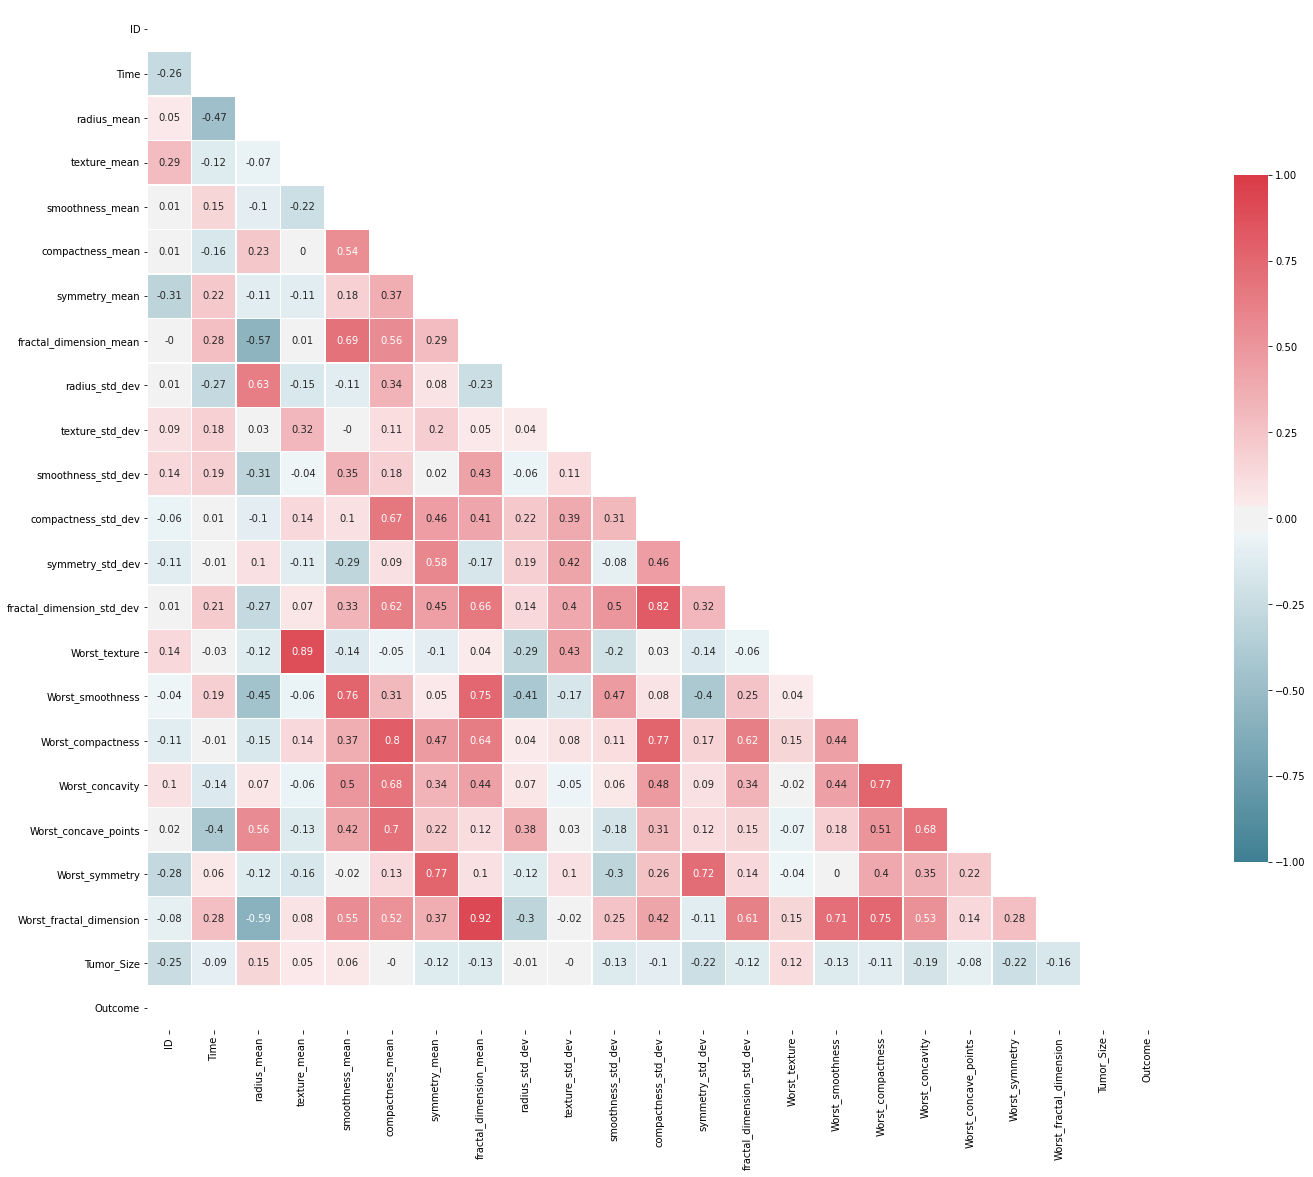

In [0]:
#We can also see from the heatmap below
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [0]:
#On the basis of feature selection
prediction_var =['radius_mean','smoothness_mean','fractal_dimension_mean','Worst_concave_points','Worst_fractal_dimension']

In [0]:
df.head()

,ID,Time,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,smoothness_std_dev,compactness_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_texture,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Outcome
4,843584,27,20.29,14.34,0.1003,0.1328,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.005115,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,1
5,843786,77,12.75,15.29,0.1189,0.1569,0.1995,0.07164,0.3877,0.7402,0.007775,0.02987,0.01774,0.005114,20.37,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,1
7,844582,77,13.71,20.83,0.1189,0.1645,0.2196,0.07451,0.5835,1.3770,0.008805,0.03029,0.01486,0.005412,28.14,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,4.0,1
13,847990,36,14.54,27.54,0.1139,0.1595,0.2303,0.07077,0.3700,1.0330,0.005607,0.04240,0.01857,0.005466,37.13,0.1678,0.6577,0.7026,0.1712,0.4218,0.13410,6.0,1
15,848620,10,16.13,20.68,0.1170,0.2022,0.2164,0.07356,0.5692,1.0730,0.007026,0.02501,0.01689,0.004142,31.48,0.1789,0.4233,0.4784,0.2073,0.3706,0.11420,3.0,1


In [0]:
X=df[prediction_var].values
X=preprocessing.scale(X)
Y = df['Time'].values 

In [0]:
print(Y)


[27 77 77 36 10 10  9  8 48 11 34 19 26 40 10 35 73  7 44  8 17 74 17 19
 39 12 37  5 58 78 24 33  4  5  2 49  1  9 16  9 14 12 11  7 14  1  3  2
 30 10  9 32 28 35 39 20 13  4 42 25 77  9 18 72 35 13 18 10 24 45  9 10
 15 18 13 61  8  9 10 14 60  9  3 10  1 18 17 32  2 48  6  2 13 42 14 41
 58 20 15 10 12 39 32 35 68  9 17  2 14 43  3 20  6  7  5 32 29 12 17 17
  9 11 51  9 34  4 12 27 21 11 34  9 12 28  9 49 36 27 31 12  5 44 50 14
 10 22  9 28 32 17 15]


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [0]:
# By decision tree Regression

In [0]:
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 50)  
  
# fit the regressor with X and Y data 
regressor.fit(X_train, Y_train) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=50, splitter='best')

In [0]:
ypred= regressor.predict(X_test)
ypred

array([78., 77.,  9., 42., 14., 17.,  3., 10., 10., 50., 15., 16., 25.,
       21., 17.,  9., 32., 11., 28., 18., 24., 17., 13., 27., 17., 42.,
       11., 16., 35.,  9., 78.])

In [0]:
mse=mean_squared_error(Y_test,ypred)
rmse=np.sqrt(mse)
rmse

17.46978959195264

In [0]:
 y_test_predict=[]

In [0]:
#By polynomial regression

In [0]:


def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  poly_features = PolynomialFeatures(degree=degree)
  
  # transform the features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  print(y_test_predict)
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
  r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
  r2_test = r2_score(Y_test, y_test_predict)
  
  print("The model performance for the training set")
  print("-------------------------------------------")
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))

  return y_test_predict

In [0]:
y_test_predict=create_polynomial_regression_model(2)

[37.4326701  52.46880785  8.64418145 29.22213505 15.09673224 28.59747716
 21.90070685 19.58704751 17.94274157 31.36438393 22.50571959 18.36343708
 22.11832891 22.47452556 22.88011529 14.16937942  3.79591973 15.99010711
 12.88631336  6.40875193 31.22195065 15.90576389 10.41139881 19.64579554
 17.17644764 23.51947814  9.4846272  25.04792268 49.70901514 12.53246363
  5.97834065]
The model performance for the training set
-------------------------------------------
RMSE of training set is 11.316674081684084
R2 score of training set is 0.6444059112947492


The model performance for the test set
-------------------------------------------
RMSE of test set is 17.232146161935212
R2 score of test set is 0.0898579646814035


In [0]:
final=pd.DataFrame(Y_test,y_test_predict)
final=pd.DataFrame({'Time':Y_test,'Prediction':y_test_predict})
final.head()

,Time,Prediction
0,24,37.432670
1,35,52.468808
2,9,8.644181
3,35,29.222135
4,27,15.096732


In [0]:
export_excel=final.to_excel('final.xlsx')

In [0]:
# Tried With different method
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)
model = LinearRegression()
model.fit(x_poly, Y_train)
y_poly_pred = model.predict(x_poly)

In [0]:
rmse = np.sqrt(mean_squared_error(Y_train,y_poly_pred))
r2 = r2_score(Y_train,y_poly_pred)
print(rmse)
print(r2)

11.949458460033746
0.5957316981292459
